In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from multihist import Histdd, Hist1d

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import hax
from hax import cuts
hax.init(pax_version_policy='6.8',
         minitree_paths=['./sr1_s1shape_minitrees/', 
                         '/project2/lgrandi/xenon1t/minitrees/pax_v6.8.0/',
                         '/project/lgrandi/xenon1t/minitrees/pax_v6.8.0/'])

from pax import units, configuration
pax_config = configuration.load_configuration('XENON1T')
tpc_r = pax_config['DEFAULT']['tpc_radius']
tpc_z = -pax_config['DEFAULT']['tpc_length']

# Select clean 83mKr events

KR83m cuts similar to Adam's note: 
https://github.com/XENON1T/FirstResults/blob/master/PositionReconstructionSignalCorrections/S2map/s2-correction-xy-kr83m-fit-in-bins.ipynb

 * Valid second interaction
 * Time between S1s in [0.6, 2] $\mu s$
 * z in [-90, -5] cm

In [3]:
# Get SR1 krypton datasets
dsets = hax.runs.datasets
dsets = dsets[dsets['source__type'] == 'Kr83m']
dsets = dsets[dsets['trigger__events_built'] > 10000]   # Want a lot of Kr, not diffusion mode 
dsets = hax.runs.tags_selection(dsets, include='sciencerun0')

# Sample ten datasets randomly (with fixed seed, so the analysis is reproducible)
dsets = dsets.sample(10, random_state=0)
dsets.number.values

array([4584, 4596, 4643, 4628, 4657, 4615, 4635, 4633, 4667, 4679])

In [4]:
# Suppress rootpy warning about root2rec.. too lazy to fix. 
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    data = hax.minitrees.load(dsets.number, 
                              'Basics DoubleScatter Corrections'.split(),
                              num_workers=5,
                              preselection=['int_b_x>-60.0',
                                            '600 < s1_b_center_time - s1_a_center_time < 2000',
                                            '-90 < z < -5'])

DEBUG:hax.minitrees] Found minitree at /project2/lgrandi/xenon1t/minitrees/pax_v6.8.0/161114_1140_Basics.root
DEBUG:hax.minitrees] Found minitree at /project2/lgrandi/xenon1t/minitrees/pax_v6.8.0/161114_1140_DoubleScatter.root
DEBUG:hax.minitrees] Found minitree at /project2/lgrandi/xenon1t/minitrees/pax_v6.8.0/161114_1140_Corrections.root
DEBUG:hax.minitrees] Found minitree at /project2/lgrandi/xenon1t/minitrees/pax_v6.8.0/161114_1140_Basics.root
DEBUG:hax.minitrees] Found minitree at /project2/lgrandi/xenon1t/minitrees/pax_v6.8.0/161114_2107_Basics.root
DEBUG:hax.minitrees] Found minitree at /project2/lgrandi/xenon1t/minitrees/pax_v6.8.0/161117_0741_Basics.root
DEBUG:hax.minitrees] Found minitree at /project2/lgrandi/xenon1t/minitrees/pax_v6.8.0/161116_1735_Basics.root
DEBUG:hax.minitrees] Found minitree at /project2/lgrandi/xenon1t/minitrees/pax_v6.8.0/161116_1030_Basics.root
DEBUG:hax.minitrees] Found minitree at /project2/lgrandi/xenon1t/minitrees/pax_v6.8.0/161114_1140_DoubleScat

(log(cs2/cs1)/log(10) > exp(-0.720893+(-0.032622)*cs1) + 1.883038 + (-7.185652e-04)*cs1) | (cs1 > 200) | (s2<150) | (largest_other_s2>200) selection: 62417 rows removed (94.06% passed)
int_b_x>-60.0 selection: 670140 rows removed (32.19% passed)
600 < s1_b_center_time - s1_a_center_time < 2000 selection: 244036 rows removed (23.30% passed)
-90 < z < -5 selection: 11517 rows removed (84.47% passed)


# Get S1s from these events

In [5]:
from hax.treemakers.peak_treemakers import PeakExtractor

dt = 10 * units.ns
wv_length = pax_config['BasicProperties.SumWaveformProperties']['peak_waveform_length']
waveform_ts = np.arange(-wv_length/2, wv_length/2 + 0.1, dt)

class GetS1s(PeakExtractor):
    __version__ = '0.0.1'
    uses_arrays = True
    # (don't actually need all properties, but useful to check if there's some problem)
    peak_fields = ['area', 'range_50p_area', 'area_fraction_top', 
                   'n_contributing_channels', 'left', 'hit_time_std', 'n_hits',
                   'type', 'detector', 'center_time', 'index_of_maximum',
                   'sum_waveform',
                  ]
    peak_cut_list = ['detector == "tpc"', 'type == "s1"']
    
    def get_data(self, dataset, event_list=None):
        # Get the event list from the dataframe selected above
        event_list = data[data['run_number'] == hax.runs.get_run_number(dataset)]['event_number'].values
        
        return PeakExtractor.get_data(self, dataset, event_list=event_list)
    
    def extract_data(self, event):
        peak_data = PeakExtractor.extract_data(self, event)
        
        # Convert sum waveforms from arcane pyroot buffer type to proper numpy arrays
        for p in peak_data:
            p['sum_waveform'] = np.array(list(p['sum_waveform']))
            
        return peak_data

In [6]:
s1s = hax.minitrees.load(dsets.number, GetS1s, num_workers=5)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/pandas/computation/align.py:98: RuntimeWarning: divide by zero encountered in log10
  ordm = np.log10(abs(reindexer_size - term_axis_size))
DEBUG:hax.minitrees] Minitree 161114_1140_GetS1s.root not found
DEBUG:hax.minitrees] Not found in non-preferred formats either. Minitree will be created.
Run 4584: Making GetS1s minitree: 100%|██████████| 1881/1881 [00:49<00:00, 38.14it/s]
DEBUG:hax.__init__] Extraction completed, now concatenating data
DEBUG:hax.minitrees] Retrieved GetS1s minitree data for dataset 4584
DEBUG:hax.minitrees] Found minitree at ./sr1_s1shape_minitrees/161114_1140_GetS1s.root
/home/aalbers/root_numpy/root_numpy/_tree.py:271: DeprecationWarning: root2rec is deprecated and will be removed in 5.0.0. Instead use root2array(...).view(np.recarray)
  DeprecationWarning)
DEBUG:hax.minitrees] Minitree 161114_2107_GetS1s.root not found
DEBUG:hax.minitrees] Not found in non-preferred formats either. Minitree wi

# Save to disk

Pandas object array is very memory-ineficient. Takes about 25 MB/dataset to store it in this format (even compressed). If we'd want to extract more than O(10) datasets we'd get into trouble already at the extraction stage.

Least we can do is convert to sensible format (waveform matrix, ordinary dataframe) now. Unfortunately dataframe retains 'object' mark even after deleting sum waveform column. Converting to and from a record array removes this.

In [7]:
waveforms = np.vstack(s1s['sum_waveform'].values)
del s1s['sum_waveform']
s1s = pd.DataFrame(s1s.to_records())

Merge with the per-event data (which is useful e.g. for making position-dependent selections)

In [8]:
merged_data = hax.minitrees._merge_minitrees(s1s, data)
del merged_data['index']

In [9]:
np.savez_compressed('sr0_kr_s1s.npz', waveforms=waveforms)
merged_data.to_hdf('sr0_kr_s1s.hdf5', 'data')

# Quick look

In [10]:
len(s1s)

134920

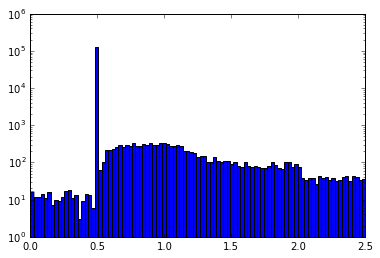

In [11]:
from pax import units
plt.hist(s1s.left * 10 * units.ns / units.ms, bins=np.linspace(0, 2.5, 100));
plt.yscale('log')

S1 is usually at trigger.

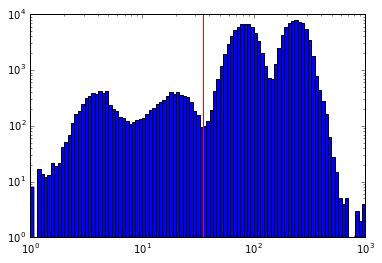

In [12]:
plt.hist(s1s.area, bins=np.logspace(0, 3, 100));
plt.axvline(35, color='r')
plt.yscale('log')
plt.xscale('log')

In [13]:
np.sum(s1s['area'] > 35)/len(s1s)

0.92600059294396675

Single electron contamination is not so severe.